<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [1]:
import pandas as pd

df = pd.read_csv('nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


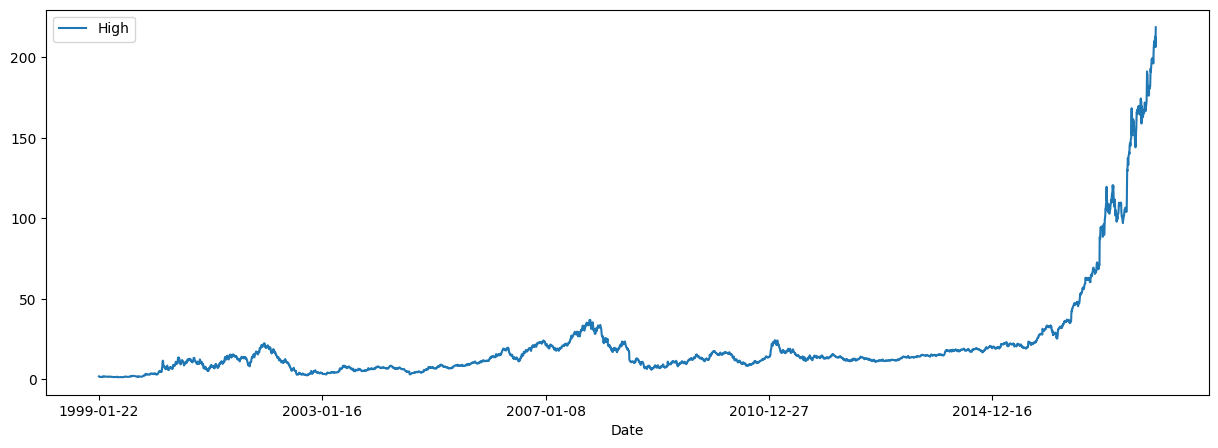

In [2]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [5]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.shape

(4733, 7)

In [8]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [9]:
import numpy as np
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df['High_Low']    = df['High'] - df['Low']
df['Close_Open']  = df['Close'] - df['Open']

scaler = StandardScaler()
df[['Open','High','Low','Close','Volume','High_Low','Close_Open']] = scaler.fit_transform(
    df[['Open','High','Low','Close','Volume','High_Low','Close_Open']]
)

df['High_next'] = df['High'].shift(-1)

feature_cols = ['Open','High','Low','Close','Volume','High_Low','Close_Open','High_next']
corr_matrix = df[feature_cols].corr()
print(corr_matrix)

                Open      High       Low     Close    Volume  High_Low  \
Open        1.000000  0.999862  0.999804  0.999658 -0.007865  0.787514   
High        0.999862  1.000000  0.999770  0.999838 -0.004774  0.792510   
Low         0.999804  0.999770  1.000000  0.999863 -0.011785  0.779262   
Close       0.999658  0.999838  0.999863  1.000000 -0.008339  0.785146   
Volume     -0.007865 -0.004774 -0.011785 -0.008339  1.000000  0.195812   
High_Low    0.787514  0.792510  0.779262  0.785146  0.195812  1.000000   
Close_Open  0.021571  0.033736  0.036891  0.047705 -0.018398 -0.063277   
High_next   0.999301  0.999553  0.999487  0.999677 -0.008394  0.785753   

            Close_Open  High_next  
Open          0.021571   0.999301  
High          0.033736   0.999553  
Low           0.036891   0.999487  
Close         0.047705   0.999677  
Volume       -0.018398  -0.008394  
High_Low     -0.063277   0.785753  
Close_Open    1.000000   0.043908  
High_next     0.043908   1.000000  


In [17]:
#features = df[['Open', 'High', 'Low', 'Close','High_Low','Close_Open']]
features = df[['Close']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=20, step=5)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (943, 20, 1)
Shape of data y: (943,)
Shape of data x_train: (679, 20, 1)
Shape of data y_train: (679,)
Shape of data x_val: (170, 20, 1)
Shape of data y_val: (170,)
Shape of data x_test: (94, 20, 1)
Shape of data y_test: (94,)
Number of samples in training and validation are 679 and 170.


## B. Defining Neural Networks

In [18]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [19]:
# Check your GPU status.
!nvidia-smi

Mon Apr 28 21:03:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P3              6W /   36W |     472MiB /   6141MiB |     34%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=1, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(1, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  1%|          | 1/100 [00:00<00:33,  2.93it/s]

Epoch 1/100, Train loss: 0.2689, Val loss: 0.1025, Best Val loss: 0.1025


  2%|▏         | 2/100 [00:00<00:27,  3.55it/s]

Epoch 2/100, Train loss: 0.0965, Val loss: 0.0670, Best Val loss: 0.0670


  3%|▎         | 3/100 [00:00<00:26,  3.71it/s]

Epoch 3/100, Train loss: 0.0385, Val loss: 0.0104, Best Val loss: 0.0104


  4%|▍         | 4/100 [00:01<00:24,  3.91it/s]

Epoch 4/100, Train loss: 0.0132, Val loss: 0.0108, Best Val loss: 0.0104


  5%|▌         | 5/100 [00:01<00:23,  4.02it/s]

Epoch 5/100, Train loss: 0.0060, Val loss: 0.0070, Best Val loss: 0.0070


  6%|▌         | 6/100 [00:01<00:22,  4.15it/s]

Epoch 6/100, Train loss: 0.0095, Val loss: 0.0133, Best Val loss: 0.0070


  7%|▋         | 7/100 [00:01<00:22,  4.23it/s]

Epoch 7/100, Train loss: 0.0076, Val loss: 0.0083, Best Val loss: 0.0070


  8%|▊         | 8/100 [00:01<00:21,  4.29it/s]

Epoch 8/100, Train loss: 0.0085, Val loss: 0.0089, Best Val loss: 0.0070


  9%|▉         | 9/100 [00:02<00:21,  4.26it/s]

Epoch 9/100, Train loss: 0.0166, Val loss: 0.0065, Best Val loss: 0.0065


 10%|█         | 10/100 [00:02<00:20,  4.32it/s]

Epoch 10/100, Train loss: 0.0114, Val loss: 0.0078, Best Val loss: 0.0065


 11%|█         | 11/100 [00:02<00:20,  4.36it/s]

Epoch 11/100, Train loss: 0.0441, Val loss: 0.0229, Best Val loss: 0.0065


 12%|█▏        | 12/100 [00:02<00:20,  4.29it/s]

Epoch 12/100, Train loss: 0.0127, Val loss: 0.0054, Best Val loss: 0.0054


 13%|█▎        | 13/100 [00:03<00:20,  4.25it/s]

Epoch 13/100, Train loss: 0.0065, Val loss: 0.0049, Best Val loss: 0.0049


 14%|█▍        | 14/100 [00:03<00:19,  4.30it/s]

Epoch 14/100, Train loss: 0.0210, Val loss: 0.0398, Best Val loss: 0.0049


 15%|█▌        | 15/100 [00:03<00:20,  4.20it/s]

Epoch 15/100, Train loss: 0.0175, Val loss: 0.0058, Best Val loss: 0.0049


 16%|█▌        | 16/100 [00:03<00:20,  4.19it/s]

Epoch 16/100, Train loss: 0.0045, Val loss: 0.0041, Best Val loss: 0.0041


 17%|█▋        | 17/100 [00:04<00:19,  4.23it/s]

Epoch 17/100, Train loss: 0.0043, Val loss: 0.0091, Best Val loss: 0.0041


 18%|█▊        | 18/100 [00:04<00:19,  4.28it/s]

Epoch 18/100, Train loss: 0.0055, Val loss: 0.0044, Best Val loss: 0.0041


 19%|█▉        | 19/100 [00:04<00:18,  4.31it/s]

Epoch 19/100, Train loss: 0.0047, Val loss: 0.0043, Best Val loss: 0.0041


 20%|██        | 20/100 [00:04<00:18,  4.32it/s]

Epoch 20/100, Train loss: 0.0082, Val loss: 0.0119, Best Val loss: 0.0041


 21%|██        | 21/100 [00:05<00:18,  4.34it/s]

Epoch 21/100, Train loss: 0.0062, Val loss: 0.0041, Best Val loss: 0.0041


 22%|██▏       | 22/100 [00:05<00:17,  4.35it/s]

Epoch 22/100, Train loss: 0.0066, Val loss: 0.0052, Best Val loss: 0.0041


 23%|██▎       | 23/100 [00:05<00:17,  4.37it/s]

Epoch 23/100, Train loss: 0.0043, Val loss: 0.0042, Best Val loss: 0.0041


 24%|██▍       | 24/100 [00:05<00:17,  4.34it/s]

Epoch 24/100, Train loss: 0.0069, Val loss: 0.0077, Best Val loss: 0.0041


 25%|██▌       | 25/100 [00:05<00:17,  4.36it/s]

Epoch 25/100, Train loss: 0.0057, Val loss: 0.0177, Best Val loss: 0.0041


 26%|██▌       | 26/100 [00:06<00:17,  4.25it/s]

Epoch 26/100, Train loss: 0.0082, Val loss: 0.0025, Best Val loss: 0.0025


 27%|██▋       | 27/100 [00:06<00:16,  4.30it/s]

Epoch 27/100, Train loss: 0.0050, Val loss: 0.0045, Best Val loss: 0.0025


 28%|██▊       | 28/100 [00:06<00:16,  4.33it/s]

Epoch 28/100, Train loss: 0.0041, Val loss: 0.0026, Best Val loss: 0.0025


 29%|██▉       | 29/100 [00:06<00:16,  4.37it/s]

Epoch 29/100, Train loss: 0.0029, Val loss: 0.0029, Best Val loss: 0.0025


 30%|███       | 30/100 [00:07<00:16,  4.29it/s]

Epoch 30/100, Train loss: 0.0030, Val loss: 0.0025, Best Val loss: 0.0025


 31%|███       | 31/100 [00:07<00:16,  4.31it/s]

Epoch 31/100, Train loss: 0.0030, Val loss: 0.0028, Best Val loss: 0.0025


 32%|███▏      | 32/100 [00:07<00:15,  4.33it/s]

Epoch 32/100, Train loss: 0.0037, Val loss: 0.0048, Best Val loss: 0.0025


 33%|███▎      | 33/100 [00:07<00:15,  4.33it/s]

Epoch 33/100, Train loss: 0.0063, Val loss: 0.0182, Best Val loss: 0.0025


 34%|███▍      | 34/100 [00:08<00:15,  4.34it/s]

Epoch 34/100, Train loss: 0.0099, Val loss: 0.0043, Best Val loss: 0.0025


 35%|███▌      | 35/100 [00:08<00:15,  4.26it/s]

Epoch 35/100, Train loss: 0.0044, Val loss: 0.0023, Best Val loss: 0.0023


 36%|███▌      | 36/100 [00:08<00:14,  4.30it/s]

Epoch 36/100, Train loss: 0.0027, Val loss: 0.0026, Best Val loss: 0.0023


 37%|███▋      | 37/100 [00:08<00:14,  4.35it/s]

Epoch 37/100, Train loss: 0.0030, Val loss: 0.0029, Best Val loss: 0.0023


 38%|███▊      | 38/100 [00:08<00:14,  4.38it/s]

Epoch 38/100, Train loss: 0.0025, Val loss: 0.0033, Best Val loss: 0.0023


 39%|███▉      | 39/100 [00:09<00:14,  4.32it/s]

Epoch 39/100, Train loss: 0.0026, Val loss: 0.0019, Best Val loss: 0.0019


 40%|████      | 40/100 [00:09<00:13,  4.35it/s]

Epoch 40/100, Train loss: 0.0024, Val loss: 0.0029, Best Val loss: 0.0019


 41%|████      | 41/100 [00:09<00:13,  4.36it/s]

Epoch 41/100, Train loss: 0.0032, Val loss: 0.0038, Best Val loss: 0.0019


 42%|████▏     | 42/100 [00:09<00:13,  4.39it/s]

Epoch 42/100, Train loss: 0.0068, Val loss: 0.0065, Best Val loss: 0.0019


 43%|████▎     | 43/100 [00:10<00:13,  4.32it/s]

Epoch 43/100, Train loss: 0.0031, Val loss: 0.0016, Best Val loss: 0.0016


 44%|████▍     | 44/100 [00:10<00:12,  4.39it/s]

Epoch 44/100, Train loss: 0.0024, Val loss: 0.0041, Best Val loss: 0.0016


 45%|████▌     | 45/100 [00:10<00:12,  4.42it/s]

Epoch 45/100, Train loss: 0.0032, Val loss: 0.0025, Best Val loss: 0.0016


 46%|████▌     | 46/100 [00:10<00:12,  4.45it/s]

Epoch 46/100, Train loss: 0.0026, Val loss: 0.0032, Best Val loss: 0.0016


 47%|████▋     | 47/100 [00:10<00:11,  4.47it/s]

Epoch 47/100, Train loss: 0.0036, Val loss: 0.0031, Best Val loss: 0.0016


 48%|████▊     | 48/100 [00:11<00:11,  4.46it/s]

Epoch 48/100, Train loss: 0.0032, Val loss: 0.0023, Best Val loss: 0.0016


 49%|████▉     | 49/100 [00:11<00:11,  4.46it/s]

Epoch 49/100, Train loss: 0.0025, Val loss: 0.0019, Best Val loss: 0.0016


 50%|█████     | 50/100 [00:11<00:11,  4.47it/s]

Epoch 50/100, Train loss: 0.0022, Val loss: 0.0028, Best Val loss: 0.0016


 51%|█████     | 51/100 [00:11<00:10,  4.48it/s]

Epoch 51/100, Train loss: 0.0026, Val loss: 0.0027, Best Val loss: 0.0016


 52%|█████▏    | 52/100 [00:12<00:10,  4.48it/s]

Epoch 52/100, Train loss: 0.0026, Val loss: 0.0028, Best Val loss: 0.0016


 53%|█████▎    | 53/100 [00:12<00:10,  4.48it/s]

Epoch 53/100, Train loss: 0.0037, Val loss: 0.0020, Best Val loss: 0.0016


 54%|█████▍    | 54/100 [00:12<00:10,  4.48it/s]

Epoch 54/100, Train loss: 0.0035, Val loss: 0.0021, Best Val loss: 0.0016


 55%|█████▌    | 55/100 [00:12<00:10,  4.47it/s]

Epoch 55/100, Train loss: 0.0022, Val loss: 0.0022, Best Val loss: 0.0016


 56%|█████▌    | 56/100 [00:12<00:09,  4.48it/s]

Epoch 56/100, Train loss: 0.0019, Val loss: 0.0023, Best Val loss: 0.0016


 57%|█████▋    | 57/100 [00:13<00:09,  4.48it/s]

Epoch 57/100, Train loss: 0.0024, Val loss: 0.0033, Best Val loss: 0.0016


 58%|█████▊    | 58/100 [00:13<00:09,  4.47it/s]

Epoch 58/100, Train loss: 0.0022, Val loss: 0.0022, Best Val loss: 0.0016


 59%|█████▉    | 59/100 [00:13<00:09,  4.48it/s]

Epoch 59/100, Train loss: 0.0020, Val loss: 0.0020, Best Val loss: 0.0016


 60%|██████    | 60/100 [00:13<00:08,  4.48it/s]

Epoch 60/100, Train loss: 0.0028, Val loss: 0.0029, Best Val loss: 0.0016


 61%|██████    | 61/100 [00:14<00:08,  4.50it/s]

Epoch 61/100, Train loss: 0.0020, Val loss: 0.0020, Best Val loss: 0.0016


 62%|██████▏   | 62/100 [00:14<00:08,  4.50it/s]

Epoch 62/100, Train loss: 0.0018, Val loss: 0.0023, Best Val loss: 0.0016


 63%|██████▎   | 63/100 [00:14<00:08,  4.51it/s]

Epoch 63/100, Train loss: 0.0019, Val loss: 0.0028, Best Val loss: 0.0016


 64%|██████▍   | 64/100 [00:14<00:08,  4.49it/s]

Epoch 64/100, Train loss: 0.0023, Val loss: 0.0023, Best Val loss: 0.0016


 65%|██████▌   | 65/100 [00:14<00:07,  4.49it/s]

Epoch 65/100, Train loss: 0.0027, Val loss: 0.0021, Best Val loss: 0.0016


 66%|██████▌   | 66/100 [00:15<00:07,  4.49it/s]

Epoch 66/100, Train loss: 0.0025, Val loss: 0.0020, Best Val loss: 0.0016


 67%|██████▋   | 67/100 [00:15<00:07,  4.50it/s]

Epoch 67/100, Train loss: 0.0024, Val loss: 0.0020, Best Val loss: 0.0016


 68%|██████▊   | 68/100 [00:15<00:07,  4.49it/s]

Epoch 68/100, Train loss: 0.0020, Val loss: 0.0017, Best Val loss: 0.0016


 69%|██████▉   | 69/100 [00:15<00:06,  4.48it/s]

Epoch 69/100, Train loss: 0.0020, Val loss: 0.0025, Best Val loss: 0.0016


 70%|███████   | 70/100 [00:16<00:06,  4.46it/s]

Epoch 70/100, Train loss: 0.0019, Val loss: 0.0019, Best Val loss: 0.0016


 71%|███████   | 71/100 [00:16<00:06,  4.48it/s]

Epoch 71/100, Train loss: 0.0018, Val loss: 0.0018, Best Val loss: 0.0016


 72%|███████▏  | 72/100 [00:16<00:06,  4.50it/s]

Epoch 72/100, Train loss: 0.0020, Val loss: 0.0019, Best Val loss: 0.0016


 73%|███████▎  | 73/100 [00:16<00:06,  4.48it/s]

Epoch 73/100, Train loss: 0.0018, Val loss: 0.0019, Best Val loss: 0.0016


 74%|███████▍  | 74/100 [00:17<00:05,  4.50it/s]

Epoch 74/100, Train loss: 0.0017, Val loss: 0.0018, Best Val loss: 0.0016


 75%|███████▌  | 75/100 [00:17<00:05,  4.51it/s]

Epoch 75/100, Train loss: 0.0017, Val loss: 0.0018, Best Val loss: 0.0016


 76%|███████▌  | 76/100 [00:17<00:05,  4.50it/s]

Epoch 76/100, Train loss: 0.0017, Val loss: 0.0018, Best Val loss: 0.0016


 77%|███████▋  | 77/100 [00:17<00:05,  4.49it/s]

Epoch 77/100, Train loss: 0.0018, Val loss: 0.0020, Best Val loss: 0.0016


 78%|███████▊  | 78/100 [00:17<00:04,  4.51it/s]

Epoch 78/100, Train loss: 0.0017, Val loss: 0.0018, Best Val loss: 0.0016


 79%|███████▉  | 79/100 [00:18<00:04,  4.48it/s]

Epoch 79/100, Train loss: 0.0017, Val loss: 0.0020, Best Val loss: 0.0016


 80%|████████  | 80/100 [00:18<00:04,  4.49it/s]

Epoch 80/100, Train loss: 0.0019, Val loss: 0.0025, Best Val loss: 0.0016


 81%|████████  | 81/100 [00:18<00:04,  4.48it/s]

Epoch 81/100, Train loss: 0.0017, Val loss: 0.0019, Best Val loss: 0.0016


 82%|████████▏ | 82/100 [00:18<00:04,  4.48it/s]

Epoch 82/100, Train loss: 0.0016, Val loss: 0.0022, Best Val loss: 0.0016


 83%|████████▎ | 83/100 [00:19<00:03,  4.49it/s]

Epoch 83/100, Train loss: 0.0017, Val loss: 0.0019, Best Val loss: 0.0016


 84%|████████▍ | 84/100 [00:19<00:03,  4.50it/s]

Epoch 84/100, Train loss: 0.0018, Val loss: 0.0020, Best Val loss: 0.0016


 85%|████████▌ | 85/100 [00:19<00:03,  4.49it/s]

Epoch 85/100, Train loss: 0.0017, Val loss: 0.0018, Best Val loss: 0.0016


 86%|████████▌ | 86/100 [00:19<00:03,  4.48it/s]

Epoch 86/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 87%|████████▋ | 87/100 [00:19<00:02,  4.47it/s]

Epoch 87/100, Train loss: 0.0017, Val loss: 0.0018, Best Val loss: 0.0016


 88%|████████▊ | 88/100 [00:20<00:02,  4.48it/s]

Epoch 88/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 89%|████████▉ | 89/100 [00:20<00:02,  4.48it/s]

Epoch 89/100, Train loss: 0.0021, Val loss: 0.0019, Best Val loss: 0.0016


 90%|█████████ | 90/100 [00:20<00:02,  4.49it/s]

Epoch 90/100, Train loss: 0.0016, Val loss: 0.0020, Best Val loss: 0.0016


 91%|█████████ | 91/100 [00:20<00:02,  4.50it/s]

Epoch 91/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 92%|█████████▏| 92/100 [00:21<00:01,  4.46it/s]

Epoch 92/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 93%|█████████▎| 93/100 [00:21<00:01,  4.48it/s]

Epoch 93/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 94%|█████████▍| 94/100 [00:21<00:01,  4.50it/s]

Epoch 94/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 95%|█████████▌| 95/100 [00:21<00:01,  4.50it/s]

Epoch 95/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 96%|█████████▌| 96/100 [00:21<00:00,  4.50it/s]

Epoch 96/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 97%|█████████▋| 97/100 [00:22<00:00,  4.51it/s]

Epoch 97/100, Train loss: 0.0019, Val loss: 0.0019, Best Val loss: 0.0016


 98%|█████████▊| 98/100 [00:22<00:00,  4.52it/s]

Epoch 98/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


 99%|█████████▉| 99/100 [00:22<00:00,  4.51it/s]

Epoch 99/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]

Epoch 100/100, Train loss: 0.0016, Val loss: 0.0019, Best Val loss: 0.0016


#### Visualizing the model performance

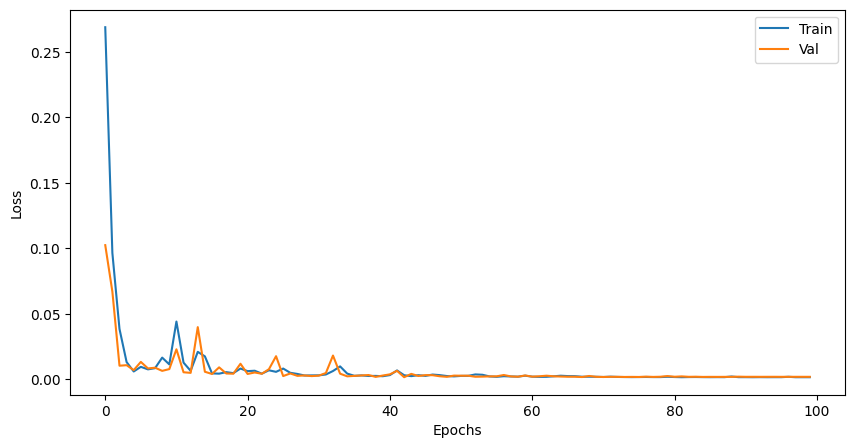

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [27]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

mse = torch.mean((pred_value - actual_value)**2)
print(f"Test MSE = {mse.item():.6f}")

Test MSE = 0.000773


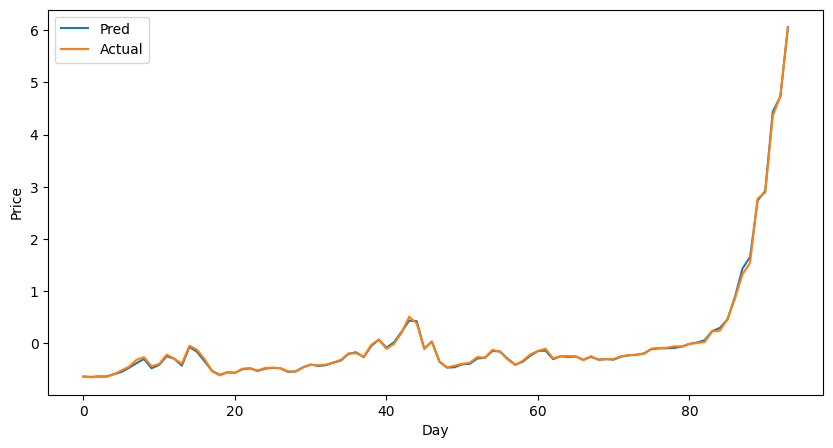

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()